In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

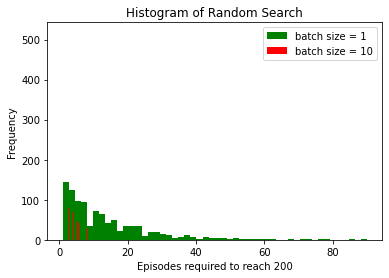

In [3]:
MAX_EPISODE_LENGTH = 200
BATCH_SIZE = 10

class Policy():
    
    def __init__(self, params):
        self.params = params
        self.max_reward = 0

    def act(self, state):
        return 0 if np.matmul(self.params,state) < 0 else 1
    
    # note that random is episodic, so we don't actually need to use the state, reward, nor the action.
    # we just use the reward at the end of the episode.
    def update(self, params, episode_reward):
        if self.max_reward > episode_reward:
            self.max_reward = episode_reward
            self.params = params
            
def run_episode(env, policy):
    
    state = env.reset()
    episode_reward = 0
    
    for _ in range(MAX_EPISODE_LENGTH):
        action = policy.act(state)
        state, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            break
            
    return episode_reward

def train_random():
    '''
    Generate random parameters each episode and keep the 
    best parameters thus far.
    '''
    env = gym.make('CartPole-v0')

    num_episodes = 0
    
    params = np.random.rand(4) * 2 - 1
    policy = Policy(params)
    
    for _ in range(10000):
        num_episodes += 1
        
        # set params within [-1, 1]
        params = np.random.rand(4) * 2 - 1
        policy = Policy(params)
       
        episode_reward = run_episode(env, policy)
        policy.update(params, episode_reward)
        
        if episode_reward == MAX_EPISODE_LENGTH:
            break

    return num_episodes

def train_random_batched(batch_size):
    '''
    Generate random parameters each episode batch and keep the 
    best parameters thus far.
    '''
    env = gym.make('CartPole-v0')

    num_batches = 0
    
    params = np.random.rand(4) * 2 - 1
    policy = Policy(params)
    
    for _ in range(10000):
        num_batches += 1
        num_episodes = 0
        
        # set params within [-1, 1]
        params = np.random.rand(4) * 2 - 1
        policy = Policy(params)
        
        batch_reward = 0
        
        for _ in range(batch_size):
            num_episodes += 1
            episode_reward = run_episode(env, policy)
            if episode_reward == MAX_EPISODE_LENGTH:
                return num_episodes
            batch_reward += episode_reward
                        
        policy.update(params, batch_reward)

    return num_episodes

def plot_random():
    
    results = []
    results_batched = []
    for _ in range(1000):
        results.append(train_random())
        results_batched.append(train_random_batched(10))

    plt.hist(results,50, color='green', label='batch size = 1')
    plt.hist(results_batched,50, color='red', label='batch size = 10')
    plt.xlabel('Episodes required to reach 200')
    plt.ylabel('Frequency')
    plt.title('Histogram of Random Search')
    plt.legend()
    plt.show()
    
    
plot_random()

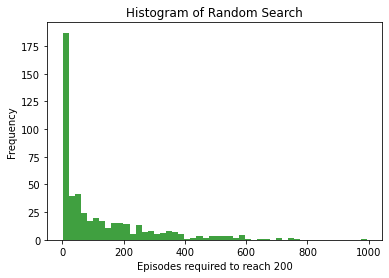

In [16]:
class Policy():
    
    def __init__(self, params):
        self.params = params
        self.max_reward = 0

    def act(self, state):
        return 0 if np.matmul(self.params,state) < 0 else 1
    
    # note that random is episodic, so we don't actually need to use the state, reward, nor the action.
    # we just use the reward at the end of the episode.
    def update(self, params, episode_reward):
        if self.max_reward > episode_reward:
            self.max_reward = episode_reward
            self.params = params
            
def run_episode(env, policy):
    
    state = env.reset()
    episode_reward = 0
    
    for _ in range(MAX_EPISODE_LENGTH):
        action = policy.act(state)
        state, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            break
            
    return episode_reward


def train_random_climb(batch_size):
    '''
    Update parameters by random noise each episode, keeping the
    best parameters thus far.
    '''
    env = gym.make('CartPole-v0')

    num_episodes = 0

    # initialize params within [-1, 1]
    params = np.random.rand(4) * 2 - 1
    eps = 0.1
    
    num_episodes = 0
    for _ in range(1000):
        noise = np.random.rand(4)*eps
        params += noise
        policy = Policy(params)
        
        batch_reward = 0
        
        for _ in range(batch_size):
            num_episodes += 1
            episode_reward = run_episode(env, policy)
            if episode_reward == MAX_EPISODE_LENGTH:
                return num_episodes
            batch_reward += episode_reward
       
        policy.update(params, batch_reward)

    return num_episodes

def plot_random_climb():
    
    results = []
    for _ in range(500):
        results.append(train_random_climb(1))

    plt.hist(results,50, facecolor='g', alpha=0.75)
    plt.xlabel('Episodes required to reach 200')
    plt.ylabel('Frequency')
    plt.title('Histogram of Random Search')
    plt.show()
    
plot_random_climb()

In [18]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("CartPole-v0")  # Create the environment
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [19]:
num_inputs = 4
num_actions = 2
num_hidden = 128

# In this architecture, the actor and the critic share all 128 hidden parameters
inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

# Dense layers have a bias weight too!!!!!
# for v in model.trainable_weights:
#     print(v.shape)
#     tf.print(v)
#     print()



In [20]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
#             env.render() 
            # Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0) # add a batch dimension

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
#             tf.print(critic_value)
            critic_value_history.append(critic_value[0, 0]) 
            # the [0, 0] is just a technicality. Our critic output looks like [[value]]

            # Sample action from action probability distribution
            action_index = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action_index]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action_index)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
#         returns = np.array(returns)
#         returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
#         returns = returns.tolist()
        
#         print(returns)
#         tf.print(critic_value_history)

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 100:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
        

running reward: 9.11 at episode 10
running reward: 24.07 at episode 20
running reward: 41.59 at episode 30
running reward: 55.80 at episode 40
running reward: 63.86 at episode 50
running reward: 66.28 at episode 60
running reward: 63.48 at episode 70
running reward: 65.57 at episode 80
running reward: 71.43 at episode 90
running reward: 75.52 at episode 100
Solved at episode 105!
